In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using PhasorNetworks

In [3]:
using Plots

In [4]:
using Random: Xoshiro, AbstractRNG

In [5]:
n_cb = 20
n_vsa = 1024

1024

In [6]:
rng0 = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [7]:
X_cb = random_symbols((n_cb, n_vsa), rng0)
Y_cb = random_symbols((n_cb, n_vsa), rng0);

In [8]:
so0 = similarity_outer(X_cb, Y_cb, dims=1);

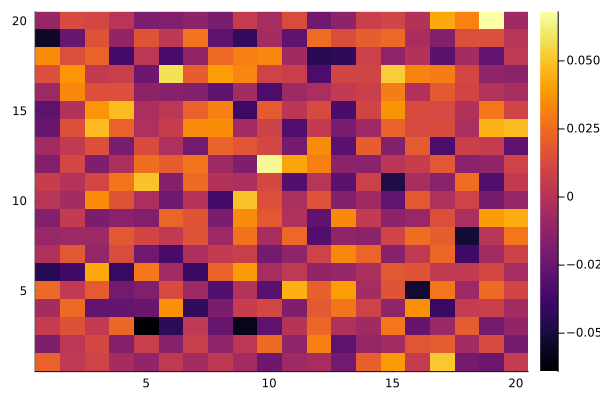

In [9]:
heatmap(so0[1,:,:])

In [10]:
rand(rng0, 1:12)

9

In [11]:
size(X_cb,1)

20

In [12]:
function generate_composition(rng::AbstractRNG, codebooks...)
    ns = [size(cb,1) for cb in codebooks]
    indices = [rand(rng, 1:n) for n in ns]
    symbols = [codebooks[i][indices[i],:] for i in 1:length(codebooks)]
    factors = stack(symbols, dims=1)
    symbol = v_bind(factors, dims=1)
    return factors, symbol
end

generate_composition (generic function with 1 method)

In [13]:
fac, sym = generate_composition(rng0, X_cb, Y_cb)

([-0.2186732292175293 -0.9460304975509644 … -0.8970067501068115 -0.2044886350631714; -0.3578685522079468 -0.6013011932373047 … 0.7725982666015625 0.5978866815567017], [-0.5765417814254761 0.45266830921173096 … -0.12440848350524902 0.3933980464935303])

In [14]:
fac

2×1024 Matrix{Float64}:
 -0.218673  -0.94603   0.00888705  …  -0.489808  -0.897007  -0.204489
 -0.357869  -0.601301  0.260257       -0.244566   0.772598   0.597887

In [15]:
sym

1×1024 Matrix{Float64}:
 -0.576542  0.452668  0.269144  -0.190194  …  -0.734373  -0.124408  0.393398

In [16]:
chk1 = similarity_outer(sym, X_cb, dims=1);

In [17]:
chk2 = similarity_outer(sym, Y_cb, dims=1);

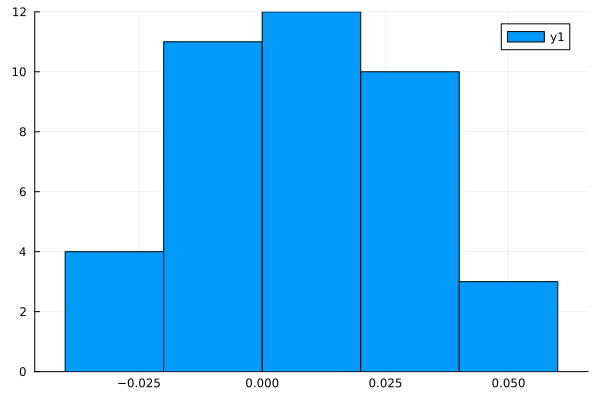

In [18]:
histogram(cat(chk1, chk2, dims=3)|> vec)

In [19]:
fac |> size

(2, 1024)

In [20]:
yy = v_unbind(sym, fac[1:1,:])

1×1024 Matrix{Float64}:
 -0.357869  -0.601301  0.260257  -0.195867  …  -0.244566  0.772598  0.597887

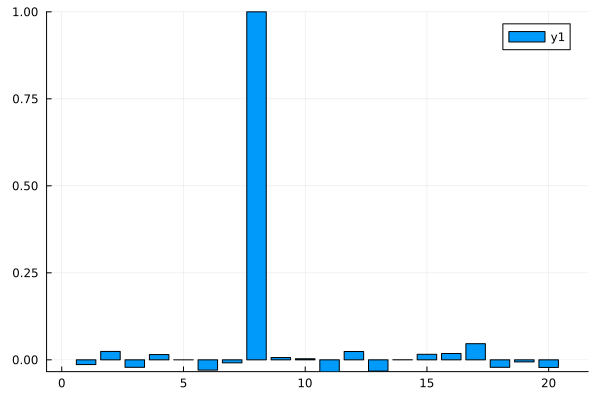

In [21]:
bar(similarity_outer(yy, Y_cb, dims=1) |> vec)

In [22]:
xx = v_unbind(sym, fac[2:2,:])

1×1024 Matrix{Float64}:
 -0.218673  -0.94603  0.00888705  …  -0.489808  -0.897007  -0.204489

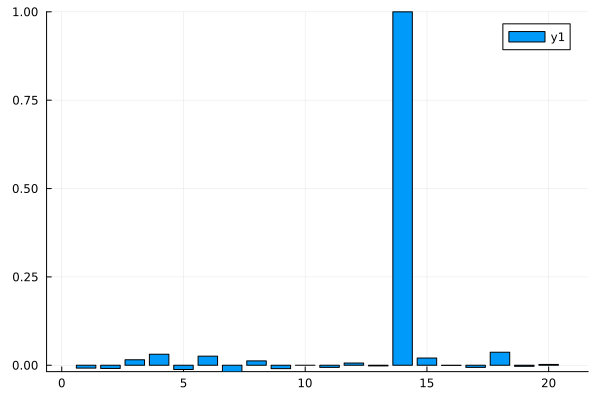

In [23]:
bar(similarity_outer(xx, X_cb, dims=1) |> vec)

In [24]:
function initialize_guesses(codebooks::AbstractArray...)
    function inner(codebook::AbstractArray)
        return v_bundle(codebook, dims=1)
    end

    guesses = collect(map(inner, codebooks))
    return guesses
end

initialize_guesses (generic function with 1 method)

In [25]:
x_cb, y_cb = initialize_guesses(X_cb, Y_cb)

2-element Vector{Matrix{Float64}}:
 [-0.3590450331537608 -0.12601368849529404 … -0.007139724235720468 0.29186573919248443]
 [0.755667336520337 0.8475005839653564 … 0.4821915168463748 -0.30048840957188777]

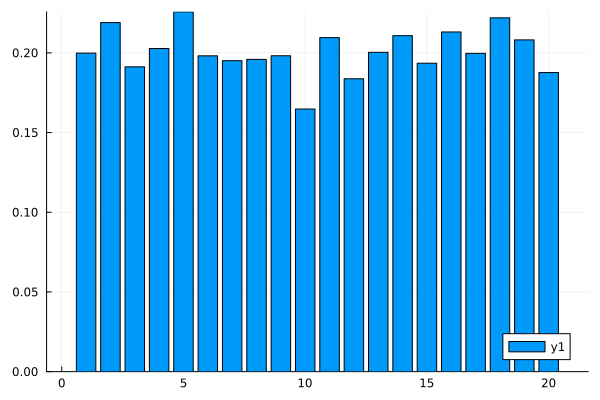

In [26]:
bar(similarity_outer(x_cb, X_cb, dims=1) |> vec)

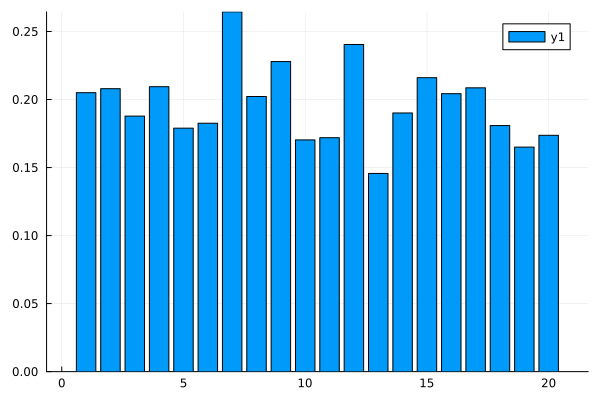

In [27]:
bar(similarity_outer(y_cb, Y_cb, dims=1) |> vec)

In [28]:
cat(x_cb, y_cb, dims=1)

2×1024 Matrix{Float64}:
 -0.359045  -0.126014   0.114846  …  -0.28906   -0.00713972   0.291866
  0.755667   0.847501  -0.128485     -0.613976   0.482192    -0.300488

In [36]:
function refine(composite::AbstractArray, factor_codebook::AbstractArray, external::AbstractMatrix)
    #bind the symbols for external factors
    external = v_bind(external, dims=1)

    #unbind external factors from the composite symbol
    factor = v_unbind(composite, external)

    #calculate the similarity to the codebook
    s = similarity_outer(factor, factor_codebook, dims=1)
    s = dropdims(s, dims=1)
    new_guess = v_bundle_project(factor_codebook, s, zeros((size(s,1), size(X_cb,2))))
    return factor, new_guess
end

refine (generic function with 1 method)

In [46]:
similarity(v_unbind(x_cb, v_bind(x_cb, y_cb)), y_cb)

1×1 Matrix{Float64}:
 -0.05970517168454775

In [49]:
similarity(x_cb, x_cb)

1×1 Matrix{Float64}:
 1.0

In [50]:
similarity(x_cb, v_unbind(v_bind(x_cb, y_cb), y_cb))

1×1 Matrix{Float64}:
 1.0

In [53]:
similarity(x_cb, v_unbind(v_bind(x_cb, y_cb), y_cb))

1×1 Matrix{Float64}:
 1.0

In [37]:
fa, xg = refine(sym, X_cb, y_cb)

([0.6677908820541869 -0.3948322747536255 … -0.6066000003516239 0.6938864560654181], [-0.14985344737800724 -0.8372790883298806 … -0.7911170388262643 -0.13517425607925773])

In [39]:
similarity(fa, x_cb)

1×1 Matrix{Float64}:
 0.04795525726763639

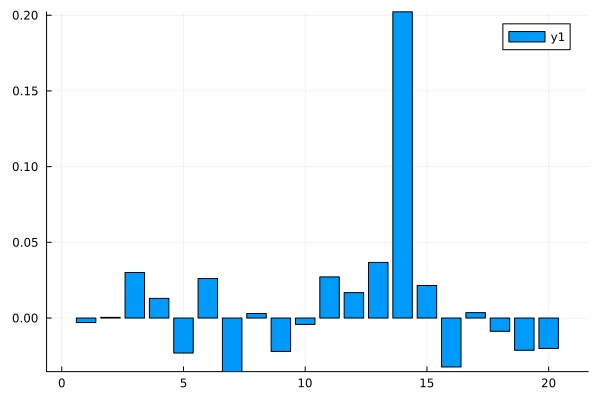

In [41]:
bar(similarity_outer(X_cb, fa, dims=1) |> vec)

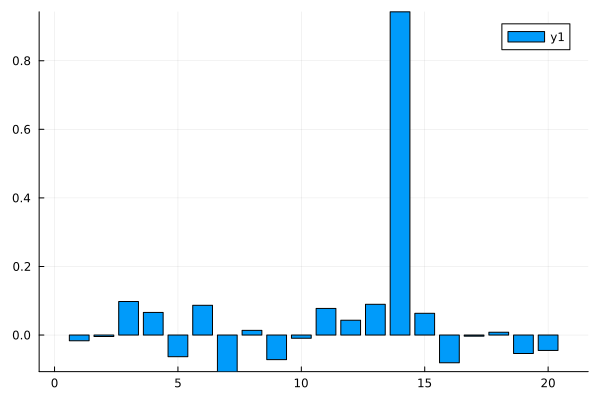

In [38]:
bar(similarity_outer(X_cb, xg, dims=1) |> vec)

In [32]:
function refine_2(composite::AbstractArray, factor_codebook::AbstractArray, internal::AbstractMatrix)
    #calculate the similarity to the codebook
    s = similarity_outer(internal, factor_codebook, dims=1)
    s = dropdims(s, dims=1)
    new_guess = v_bundle_project(factor_codebook, s, zeros((size(s,1), size(X_cb,2))))
    return new_guess
end

refine_2 (generic function with 1 method)

In [33]:
xg2 = refine_2(sym, X_cb, x_cb)

1×1024 Matrix{Float64}:
 -0.368463  -0.0933064  0.0926778  …  -0.274405  -0.00554473  0.306306

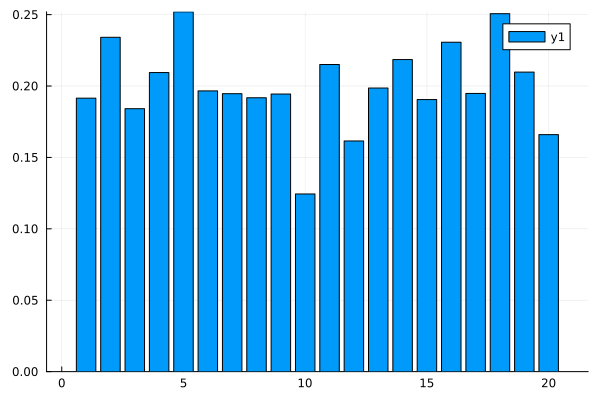

In [34]:
bar(similarity_outer(X_cb, xg2, dims=1) |> vec)

In [132]:
function resonate(composite::AbstractArray, iterations::Int, codebooks::AbstractArray...)
    n_factors = length(codebooks)
    i_factors = collect(1:n_factors)
    #create the initial guesses for the symbol components
    components = initialize_guesses(codebooks...)
    guesses = [cat(components..., dims=1),]

    #refine the guess on one factor
    function refine_inner(ind::Int, components)
        #what is the factor we are refining
        factor = components[ind]
        #what are the other factors
        external_i = setdiff(i_factors, ind)
        externals = getindex(components, external_i, :)
        #refine the factor
        refined_factor = refine(composite, codebooks[ind], externals)
        return refined_factor
    end

    for iter in 1:iterations
        new_guesses = [refine_inner(i, guesses[iter]) for i in 1:n_factors]
        new_guesses = cat(new_guesses..., dims=1)
        push!(guesses, new_guesses)
    end

    guesses = 
    return guesses
end

resonate (generic function with 1 method)

In [133]:
g = resonate(sym, 10, X_cb, Y_cb)

11-element Vector{Matrix{Float64}}:
 [-0.3590450331537608 -0.12601368849529404 … -0.007139724235720468 0.29186573919248443; 0.755667336520337 0.8475005839653564 … 0.4821915168463748 -0.30048840957188777]
 [-0.14985344737800724 -0.8372790883298806 … -0.7911170388262643 -0.13517425607925773; -0.23769526263281773 -0.6020818517900124 … 0.8035818856262866 0.611901566764327]
 [-0.2340597196729223 -0.9194458383323258 … -0.8785935910971346 -0.18919584659899027; -0.3311498612460004 -0.6267853135293322 … 0.7643070848682739 0.6150019618165247]
 [-0.2367980169518977 -0.9365565771105606 … -0.8824621325120504 -0.20018571465426413; -0.3298275074071503 -0.6386605745342429 … 0.7716713640010059 0.6252094074793294]
 [-0.23746748428525563 -0.9365170952990899 … -0.8826051942216363 -0.20104857532461357; -0.3309256005362857 -0.6390284152640691 … 0.7717801687465969 0.6246541328757405]
 [-0.2374837487680688 -0.9367124792787541 … -0.8826251565657471 -0.2011289750164333; -0.33092478435831696 -0.6390578873860573 

In [141]:
xmapfn = x -> vec(similarity_outer(x[1:1,:], X_cb, dims=1))

#77 (generic function with 1 method)

In [149]:
ymapfn = x -> vec(similarity_outer(x[2:2,:], Y_cb, dims=1))

#79 (generic function with 1 method)

In [150]:
xsims = cat(collect(map(xmapfn, g))..., dims=2);

In [151]:
ysims = cat(collect(map(ymapfn, g))..., dims=2);

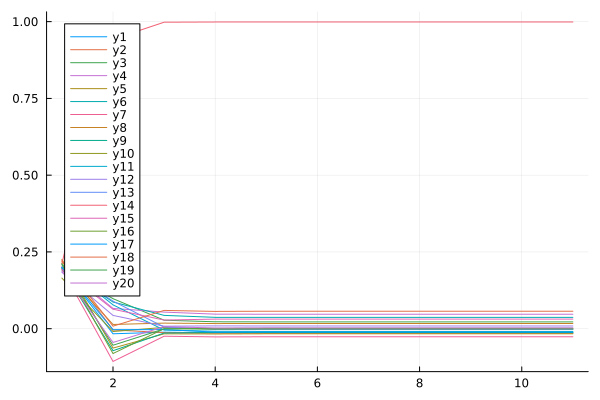

In [148]:
plot(xsims')

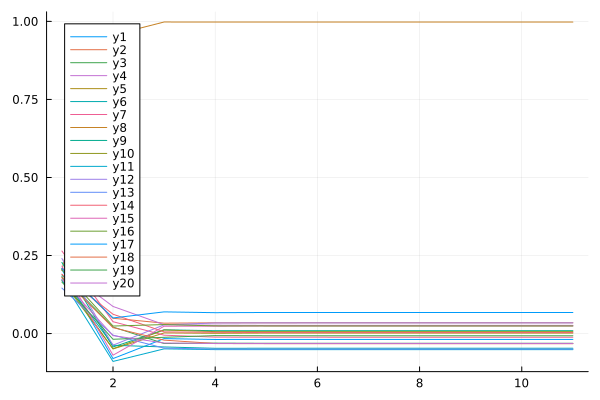

In [152]:
plot(ysims')

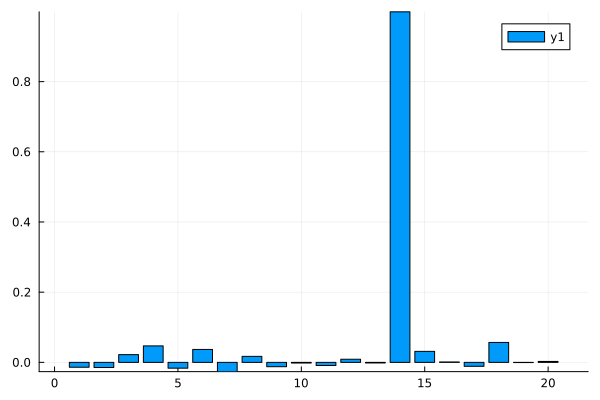

In [ ]:
plot(similarity_outer(g[end][1:1,:], X_cb, dims=1) |> vec)

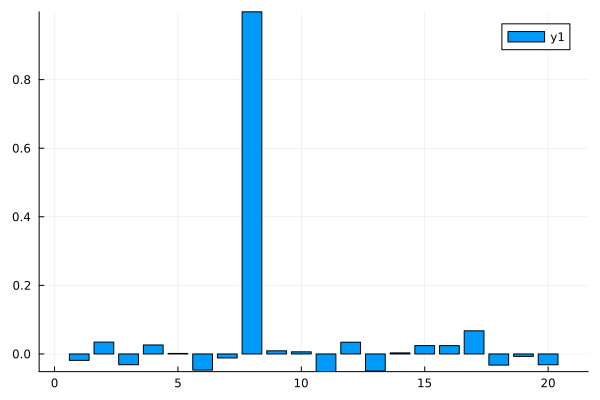

In [153]:
bar(similarity_outer(g[end][2:2,:], Y_cb, dims=1) |> vec)